In [1]:
import sys
sys.path.append("../")

In [2]:
import toml
from src.dataset import AudioToTextDataLayer
from src.helpers import add_ctc_labels, print_dict, __ctc_decoder_predictions_tensor
from src.model import AudioPreprocessing, GreedyCTCDecoder, JasperEncoderDecoder
from src.parts.features import audio_from_file
import torch
import random
import numpy as np
import time

In [3]:
def run_once(audio_processor, encoderdecoder, greedy_decoder, audio, audio_len, labels):
            features = audio_processor(audio, audio_len)
            torch.cuda.synchronize()
            t0 = time.perf_counter()
            t_log_probs_e = encoderdecoder(features[0])
            torch.cuda.synchronize()
            t1 = time.perf_counter()
            t_predictions_e = greedy_decoder(log_probs=t_log_probs_e)
            hypotheses = __ctc_decoder_predictions_tensor(t_predictions_e, labels=labels)
            print("INFERENCE TIME\t\t: {} ms".format((t1-t0)*1000.0))
            print("TRANSCRIPT\t\t:", hypotheses[0])


def inference(wav, model, model_toml, seed=42, cudnn_benchmark=False):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = cudnn_benchmark
    print("CUDNN BENCHMARK ", cudnn_benchmark)

    optim_level = 0

    jasper_model_definition = toml.load(model_toml)
    dataset_vocab = jasper_model_definition['labels']['labels']
    ctc_vocab = add_ctc_labels(dataset_vocab)

    featurizer_config = jasper_model_definition['input_eval']
    featurizer_config["optimization_level"] = optim_level
    use_conv_mask = jasper_model_definition['encoder'].get('convmask', True)
        
    print('=== model_config ===')
    print_dict(jasper_model_definition)
    print('=== feature_config ===')
    print_dict(featurizer_config)
    data_layer = None
    
    audio_preprocessor = AudioPreprocessing(**featurizer_config)
    encoderdecoder = JasperEncoderDecoder(jasper_model_definition=jasper_model_definition, feat_in=1024, num_classes=len(ctc_vocab))

    print("loading model from ", model)
    checkpoint = torch.load(model, map_location="cpu")
    for k in audio_preprocessor.state_dict().keys():
        checkpoint['state_dict'][k] = checkpoint['state_dict'].pop("audio_preprocessor." + k)
    audio_preprocessor.load_state_dict(checkpoint['state_dict'], strict=False)
    encoderdecoder.load_state_dict(checkpoint['state_dict'], strict=False)

    greedy_decoder = GreedyCTCDecoder()

    print ("audio_preprocessor.normalize: ", audio_preprocessor.featurizer.normalize)

    audio_preprocessor.eval()
    encoderdecoder.eval()
    greedy_decoder.eval()
    
    audio, audio_len = audio_from_file(wav)
    
    run_once(audio_processor, encoderdecoder, greedy_decoder, audio, audio_len, ctc_vocab)

In [4]:
inference("example1.wav", "../models/Jasper_1612265229.5877585-epoch-179.pt", "../configs/jasper10x5dr_sp_offline_specaugment.toml", seed=42)

CUDNN BENCHMARK  False
=== model_config ===
Arguments:
	   encoder : {'activation': 'relu', 'convmask': True}
	     input : {'normalize': 'per_feature', 'sample_rate': 16000, 'window_size': 0.02, 'window_stride': 0.01, 'window': 'hann', 'features': 64, 'n_fft': 512, 'frame_splicing': 1, 'dither': 1e-05, 'feat_type': 'logfbank', 'normalize_transcripts': True, 'trim_silence': True, 'pad_to': 16, 'max_duration': 15, 'speed_perturbation': True, 'cutout_rect_regions': 0, 'cutout_rect_time': 60, 'cutout_rect_freq': 25, 'cutout_x_regions': 2, 'cutout_y_regions': 2, 'cutout_x_width': 6, 'cutout_y_width': 6}
	input_eval : {'normalize': 'per_feature', 'sample_rate': 16000, 'window_size': 0.02, 'window_stride': 0.01, 'window': 'hann', 'features': 64, 'n_fft': 512, 'frame_splicing': 1, 'dither': 1e-05, 'feat_type': 'logfbank', 'normalize_transcripts': True, 'trim_silence': True, 'pad_to': 16, 'optimization_level': 0}
	    jasper : [{'filters': 256, 'repeat': 1, 'kernel': [11], 'stride': [2], 'dila

In [21]:
import pyaudio

CHUNK = 4024
WIDTH = 2
CHANNELS = 1
RATE = 16000
RECORD_SECONDS = 5

p = pyaudio.PyAudio()

stream = p.open(format=p.get_format_from_width(WIDTH),
                channels=CHANNELS,
                rate=RATE,
                input=True,
                output=True,
                frames_per_buffer=CHUNK)

print("* recording")
frames = []
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    frames.append(stream.read(CHUNK))  #read audio stream
#     stream.write(data, CHUNK)  #play back audio stream

data = b''.join(frames)
print("* done")

stream.stop_stream()
stream.close()

p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(data)
wf.close()

* recording
* done


In [55]:
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct

sample_rate, signal = scipy.io.wavfile.read('eu_0.wav')

In [57]:
signal.shape

(264528,)

In [23]:
def plot_wave(wave):
    plt.title("Signal Wave...")
    plt.plot(wave)
    plt.show()

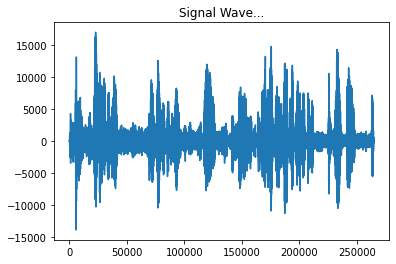

In [58]:
plot_wave(signal)

## Pré-Ênfase

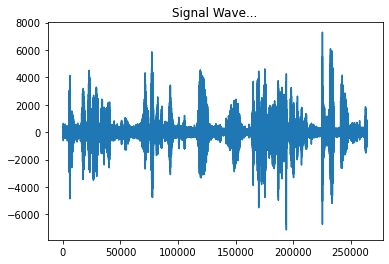

In [97]:
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
plot_wave(emphasized_signal)

In [100]:
frame_size = .3
frame_stride = .001

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

In [104]:
frames.shape

(16233, 4800)

In [106]:
numpy.hamming(frame_length).shape

(4800,)

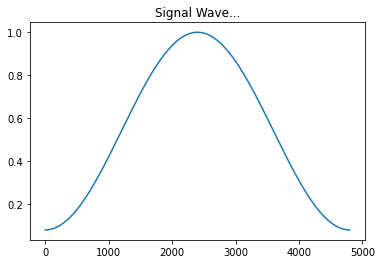

In [105]:
frames *= numpy.hamming(frame_length)
plot_wave(numpy.hamming(frame_length))

In [108]:
NFFT = 512
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

In [111]:
pow_frames.shape

(16233, 257)

In [119]:
def plot_spectogram(s2):
    # Plot the spectrogram
    plt.imshow(s2,  cmap='jet', aspect='auto')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    plt.show()   

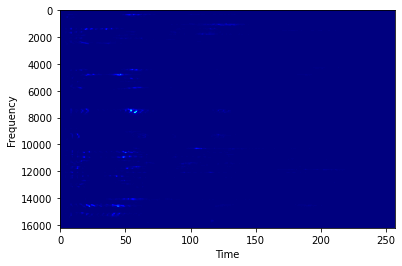

In [120]:
plot_spectogram(pow_frames)

In [125]:
pow_frames.shape

(16233, 257)

In [155]:
fbank[0]

array([0.        , 1.27941993, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [162]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

/home/lucas/Documents/Projetos/audio-transcription/venv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10


In [124]:
filter_banks.shape

(16233, 40)

In [147]:
import librosa
f = librosa.filters.mel(sample_rate,NFFT, n_mels=nfilt, fmin=0, fmax=sample_rate / 2)

In [161]:
f[0]

array([0.        , 0.0057736 , 0.0115472 , 0.00986414, 0.00409054,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [126]:
filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)

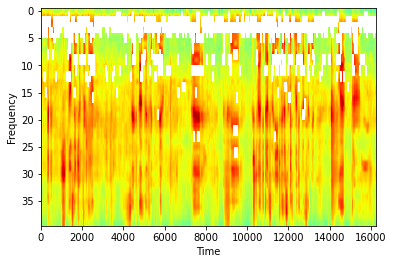

In [164]:
plot_spectogram(filter_banks.T)